In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.classification import log_loss
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from scipy.sparse import hstack
import seaborn as sns

import xgboost as xgb

from prettytable import PrettyTable

In [2]:
#reading train, test and CV data
train = pd.read_csv('nlp_features_train.csv');
test  = pd.read_csv('nlp_features_test.csv');
cv    = pd.read_csv('nlp_features_cv.csv');

In [3]:
#to avoid decoding problem
def convert_str(df):
    df['question1'] = df['question1'].apply(lambda x: str(x))
    df['question2'] = df['question2'].apply(lambda x: str(x))
    return df

In [4]:
train = convert_str(train);
test  = convert_str(test);
cv = convert_str(cv);

## Featurizing question1 using tfidfVectorizer

In [5]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=5000);
vectorizer.fit(train['question1'].values)

train_q1 = vectorizer.transform(train['question1'].values)
test_q1 = vectorizer.transform(test['question1'].values)
cv_q1 = vectorizer.transform(cv['question1'].values)

## Featurizing question2 using tfidfVectorizer

In [6]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=5000)
vectorizer.fit(train['question2'].values)

train_q2 = vectorizer.transform(train['question2'].values)
test_q2 = vectorizer.transform(test['question2'].values)
cv_q2 = vectorizer.transform(cv['question2'].values)

In [7]:
train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1Len', 'q2Len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

### dropping question1, question2, id, qid1, qid2 columns 

In [8]:
train = train.drop(['question1', 'question2', 'id', 'qid1', 'qid2'], axis=1)
test = test.drop(['question1', 'question2', 'id', 'qid1', 'qid2'], axis=1)
cv = cv.drop(['question1', 'question2', 'id', 'qid1', 'qid2'], axis=1)

### Converting all columns value to numeric

In [9]:
def convert_numeric(data):
    cols = list(data.columns)
    for i in cols:
        data[i] = data[i].apply(pd.to_numeric)
    return data

In [10]:
train = convert_numeric(train);
test  = convert_numeric(test);
cv = convert_numeric(cv);

### Splitting data into input and output

In [11]:
y_train = train['is_duplicate']
y_test = test['is_duplicate']
y_cv = cv['is_duplicate']

### dropping is_duplicate

In [12]:
train = train.drop(['is_duplicate'], axis=1)
cv = cv.drop(['is_duplicate'], axis=1)
test = test.drop(['is_duplicate'], axis=1)

### Merging data

In [13]:
train_data = []
test_data = []
cv_data = []
for column in train.columns:
    train_data.append(train[column].values.reshape(-1,1))
    test_data.append(test[column].values.reshape(-1,1))
    cv_data.append(cv[column].values.reshape(-1,1))
    
train_data.extend([train_q1, train_q2])
test_data.extend([test_q1, test_q2])
cv_data.extend([cv_q1, cv_q2])

In [14]:
X_train = hstack(train_data).tocsr()
X_test = hstack(test_data).tocsr()
X_cv = hstack(cv_data).tocsr()

In [15]:
print(X_train.shape, X_test.shape, X_cv.shape)

(198102, 10026) (121287, 10026) (84901, 10026)


### Defining function to plot confustion matrix, precission and recall matrix

In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    #finding recall matrix
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    #finding precision matrix
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]

    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    ax = sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"fontsize":15})
    ax.set_ylim(2.0,0)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    ax = sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"fontsize":15})
    ax.set_ylim(2.0, 0)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    ax = sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"fontsize":15})
    ax.set_ylim(2.0, 0)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8869302650394857


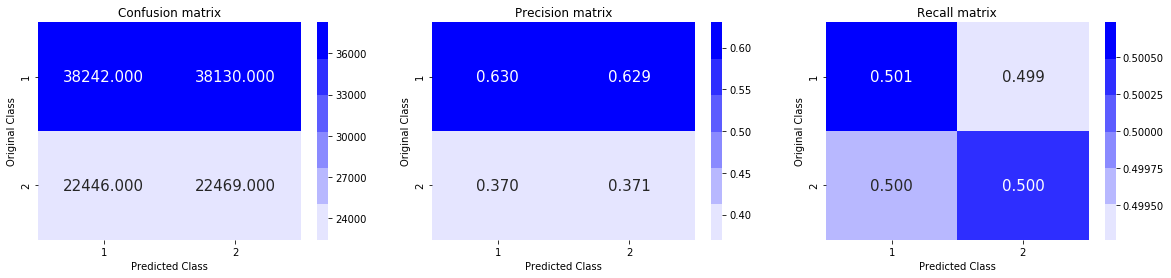

In [17]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
test_len = X_test.shape[0]
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression

In [18]:
alphas = [10 ** x for x in range(-5, 2)] 

log_error_array = []

for alpha in alphas:
    #SGDClassifier with log loss => logistic Regression
    clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=43)
    clf.fit(X_train, y_train)
    
    #finding calibrated probability
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    
    predict_y = sig_clf.predict_proba(X_cv)
    loss = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
    log_error_array.append(loss)
    print('For values of alpha = ', alpha, "The log loss is:",loss)


For values of alpha =  1e-05 The log loss is: 0.6585903042776905
For values of alpha =  0.0001 The log loss is: 0.6585903042776905
For values of alpha =  0.001 The log loss is: 0.6585903042776905
For values of alpha =  0.01 The log loss is: 0.6585903042776905
For values of alpha =  0.1 The log loss is: 0.658486713430322
For values of alpha =  1 The log loss is: 0.6179801819774735
For values of alpha =  10 The log loss is: 0.5987116826890708


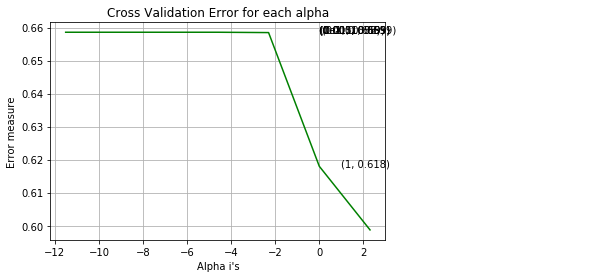

In [19]:

fig, ax = plt.subplots()
ax.plot(np.log(alphas), log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


### training Logistic Regression with best alpha

In [20]:
best_alpha = alphas[np.argmin(log_error_array)]

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                              

For values of best alpha =  10 The train log loss is: 0.5879722805764982
For values of best alpha =  10 The test log loss is: 0.5967254781144085
Total number of data points : 121287


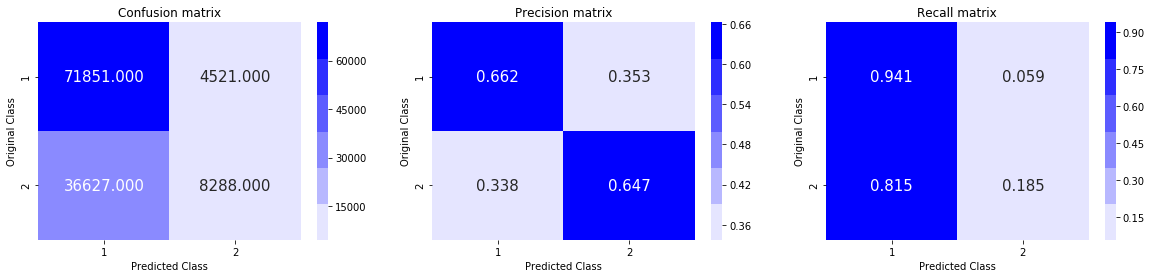

In [21]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## SVM

In [17]:
alphas = [10 ** x for x in range(-5, 2)]
log_error_array=[]
for alpha in alphas:
    clf = SGDClassifier(alpha=alpha, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For values of alpha = ', alpha, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 0.6585903042776905
For values of alpha =  0.0001 The log loss is: 0.6585903042776905
For values of alpha =  0.001 The log loss is: 0.640871959596003
For values of alpha =  0.01 The log loss is: 0.5898463554893242
For values of alpha =  0.1 The log loss is: 0.6114483076781245
For values of alpha =  1 The log loss is: 0.6470404363548193
For values of alpha =  10 The log loss is: 0.6395147516863886


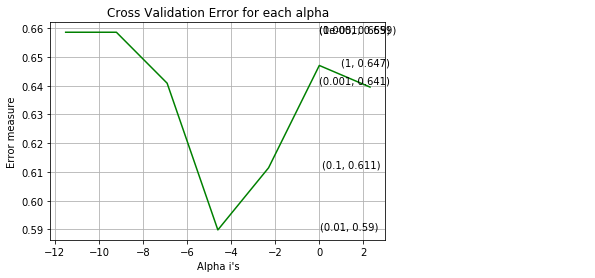

In [18]:

fig, ax = plt.subplots()
ax.plot(np.log(alphas), log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [ ]:
log_error_array

### training SVM with best alpha

In [19]:
best_alpha = alphas[np.argmin(log_error_array)]

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                          

For values of best alpha =  0.01 The train log loss is: 0.6581318936502598
For values of best alpha =  0.01 The test log loss is: 0.6591331453996517
Total number of data points : 121287


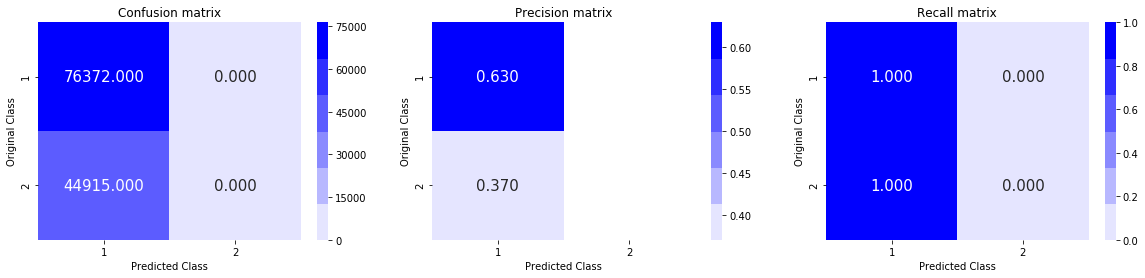

In [20]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost

In [26]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 4, 5]
        }

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)

clf = xgb.XGBClassifier(
    learning_rate=0.02, 
    n_estimators=600, 
    objective='binary:logistic',
    silent=True, 
    nthread=1
)

random_search = RandomizedSearchCV(
    clf, 
    param_distributions=params, 
    n_iter=5, 
    scoring='neg_log_loss',
    n_jobs=-1, 
    cv=skf.split(X_train,y_train), 
    verbose=3, 
    random_state=1001 
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 71.0min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000020242E33F10>,
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=1,
                                           obje...ic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True, subsample=1,
           

In [27]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

In [28]:
xgb_clf = xgb.XGBClassifier(
    learning_rate=0.02, 
    n_estimators=500, 
    max_depth=4,
    min_child_weight=1,
    objective='binary:logistic',
    silent=True, 
    nthread=1,    
)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

In [29]:
sig_clf = CalibratedClassifierCV(xgb_clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1, gamma=0,
                                                    learning_rate=0.02,
                                                    max_delta_step=0,
                                                    max_depth=4,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=600, n_jobs=1,
                                                    nthread=1,
                                                    objective='binary:logistic',
                                                    random_state=0,

In [31]:
predict_y = sig_clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=xgb_clf.classes_, eps=1e-15))

The test log loss is: 0.40031879343141796


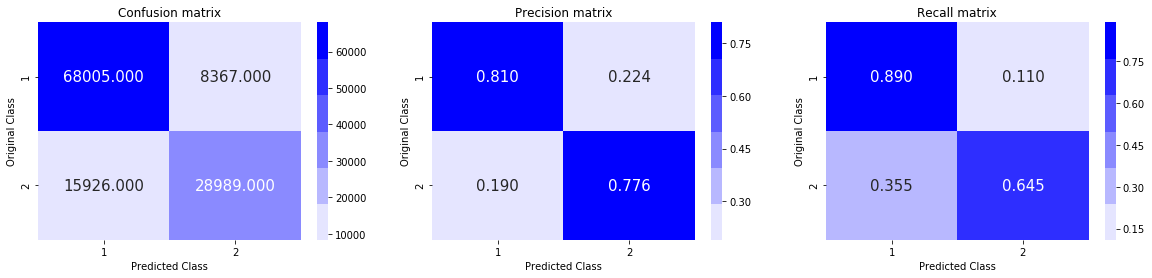

In [32]:
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Summary

In [34]:
table = PrettyTable()
table.field_names = ['Model', 'Loss']
table.add_row(['Random', '0.887638201070377'])
table.add_row(['Logistic Regression', '0.5967254781144085'])
table.add_row(['SVM','0.6591331453996517'])
table.add_row(['XGBoost', '0.40031879343141796'])
print(table)

+---------------------+---------------------+
|        Model        |         Loss        |
+---------------------+---------------------+
|        Random       |  0.887638201070377  |
| Logistic Regression |  0.5967254781144085 |
|         SVM         |  0.6591331453996517 |
|       XGBoost       | 0.40031879343141796 |
+---------------------+---------------------+


## Observation:
- Using Tfidf vectorizer for vectorizing text data, we are getting minimum loss using XGBoost